In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

Hamiltonian with open boundary conditions:

$\displaystyle H = -\sum_n^N  h_n\sigma_z(n) - \sum_n^{N-1} [ J_n^x\sigma_x(n) \sigma_x(n+1) + J_n^y\sigma_y(n) \sigma_y(n+1)]$

Hamiltonian with periodic boundary conditions:

$\displaystyle H = -\sum_n^N  h_n\sigma_z(n) - \sum_n^{N} [ J_n^x\sigma_x(n) \sigma_x(n+1) + J_n^y\sigma_y(n) \sigma_y(n+1)]$

where $\sigma_{x,y}(n+1)=\sigma_{x,y}(1)$

$h_n$ - transverse field,
$J_n^{x,y}$ - couplings

In [2]:
def generate_Hamiltonian(N, h, Jx, Jy, periodic = False):
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - h[n] * sz_list[n]

    # interaction terms
    for n in range(N-1):
        H += - Jx[n] * sx_list[n] * sx_list[n+1]
        H += - Jy[n] * sy_list[n] * sy_list[n+1]

    # adding terms for periodic boundary condition, interaction of spin N and spin 1
    if periodic == True:
        H += - Jx[N-1] * sx_list[N-1] * sx_list[0]
        H += - Jy[N-1] * sy_list[N-1] * sy_list[0]
        
    return H

def entanglement_entropy(state, partition):
    # Returns the Von Neumann entropy of the partial trace
    # state - state for which we want to calculate the entanglement entropy
    # partition - integer or array of integers from 0 to N-1 that indicate the subsystem
    # with respect to which we calculate the partial trace
    dm = state*state.dag()
    partial_dm = dm.ptrace(partition)
    return entropy_vn(partial_dm, base = 2)

def generate_state(N, llista):
    # N - total number of spins
    # llista - list of numbers from 0 to N-1 that indicate when a spin is flipped
    a = np.zeros(N)
    for i in llista:
        a[i] = 1
    basis_list = []
    for i in range(N):
        if a[i] == 0:
            basis_list.append(basis(2,0))
        if a[i] == 1:
            basis_list.append(basis(2,1))
    state = tensor(basis_list)
    return state

def evolve_state(H, psi0, tlist, plot = True):
    # evolve and calculate expectation values
    c_op_list = []
    si = qeye(2)
    sz = sigmaz()
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
    result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    result_state = mesolve(H, psi0, tlist, c_op_list)
    
    if plot == True:
        plt.subplots(figsize=(10,6))
        plt.imshow(np.real(result.expect), interpolation = 'nearest', extent=[tlist[0], tlist[-1], 0,N ], aspect = 'auto')
        plt.aspect_ratio = 1
        plt.colorbar()
        plt.xlabel(r'Time')
        plt.ylabel(r'N site')
        plt.title(r'$\langle\sigma_z\rangle$ evolution of a spin chain');
    return result.expect, result_state.states

def correlation_spins(state, i, N):
    ## Calculate the correlation of spin i with the rest of spins j
    # \sigma^x_i\sigma^x_j for a given state
    # state is going to be the ground state of a Hamiltonian
    # N is the length of the spin chain
    si = qeye(2)
    sx = sigmax()
    sx_list = []
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))
    
    correlations = []
    for j in range(N):
        operator = sx_list[i]*sx_list[j]
        correlations.append(expect(operator, state))
    return correlations
    
from random import sample
from random import randint

def generate_random_partition(N):
    basic_list = [i for i in range(N)]
    m = randint(1,N-1)
    partition = np.sort(sample(basic_list, m))
    return partition

$\displaystyle H = -J\{\sum_n^N  h/J\sigma_z(n) + \sum_n^{N-1} [ \frac{(1+\kappa)}{2}\sigma_x(n) \sigma_x(n+1) + \frac{(1-\kappa)}{2}\sigma_y(n) \sigma_y(n+1)]\}$

Text(0, 0.5, 'Ground state Energy')

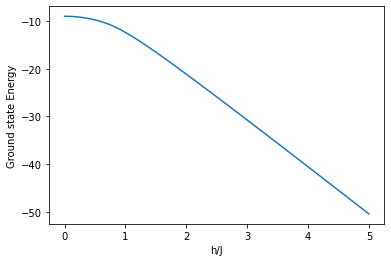

In [60]:
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = np.linspace(0,5,50)
E = [] # energy of the ground state
entanglement1 = [] # entanglement entropy of the ground state
entanglement2 = []
for i in range(len(h)):
    h_i = h[i]*np.ones(N)

    H = generate_Hamiltonian(N, h_i, Jx, Jy)
    ground = H.groundstate(sparse=False, tol=0, maxiter=100000)
    E.append(ground[0])
    entanglement1.append(entanglement_entropy(ground[1], [1,4]))
    entanglement2.append(entanglement_entropy(ground[1], [1,4,6,8]))
plt.plot(h, E)
plt.xlabel('h/J')
plt.ylabel('Ground state Energy')


Maximum entanglement for partition 2 happens at h/J =  0.9183673469387755
Maximum entanglement for partition 1 happens at h/J =  0.8163265306122449


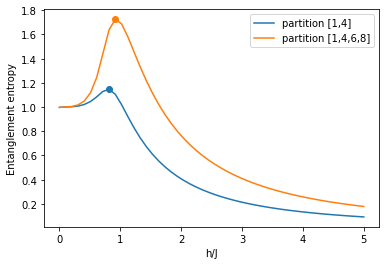

In [61]:
# Entanglement entropy of the ground state
plt.plot(h,entanglement1, label = 'partition [1,4]')
plt.scatter(h[entanglement1.index(max(entanglement1))],max(entanglement1))
plt.plot(h,entanglement2, label = 'partition [1,4,6,8]')
plt.scatter(h[entanglement2.index(max(entanglement2))],max(entanglement2))
plt.xlabel('h/J')
plt.ylabel('Entanglement entropy')
plt.legend()
print('Maximum entanglement for partition 2 happens at h/J = ',h[entanglement2.index(max(entanglement2))])
print('Maximum entanglement for partition 1 happens at h/J = ',h[entanglement1.index(max(entanglement1))])

Now we will fix h/J = 1 and will see for which partition of the system we have the maximum entanglement entropy

# Entaglement entropy for different partitions

In [56]:
n_partitions = 50 # number of partitions that we will try
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = np.ones(N)

partitions = []
for i in range(n_partitions):
    partitions.append(generate_random_partition(N))

entanglement = []
H = generate_Hamiltonian(N, h, Jx, Jy)
ground = H.groundstate(sparse=False, tol=0, maxiter=100000)
for j in partitions:
    entanglement.append(entanglement_entropy(ground[1], j))

sorted_partitions = []
for i in np.argsort(entanglement):
    sorted_partitions.append(partitions[i])

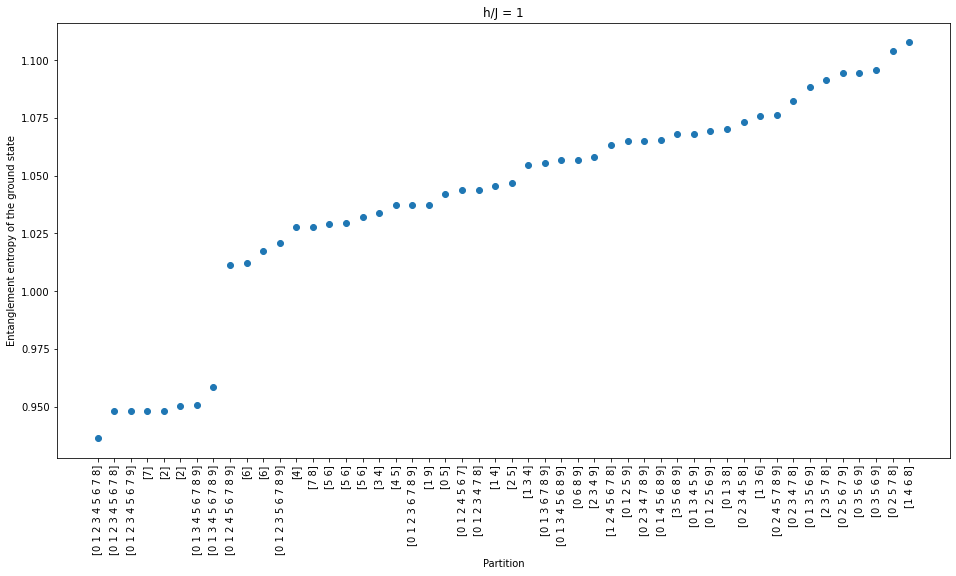

In [57]:
plt.figure(figsize = (16,8))
plt.scatter(range(n_partitions), np.sort(total_entanglement[1]))
partition_labels = []
for i in sorted_partitions:
    partition_labels.append(str(i))
plt.title('h/J = 1')
plt.ylabel('Entanglement entropy of the ground state')
plt.xlabel('Partition')
plt.xticks(range(n_partitions), partition_labels, rotation=90)  # Set text labels and properties.
plt.show()

In [58]:
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = [0, 0.5, 1, 1.5]

all_entanglement = []
for i in h:
    h_i = i*np.ones(N)
    H = generate_Hamiltonian(N, h_i, Jx, Jy)
    ground = H.groundstate(sparse=False, tol=0, maxiter=100000)
    entanglement = []
    for j in sorted_partitions:
        entanglement.append(entanglement_entropy(ground[1], j))
    all_entanglement.append(entanglement)

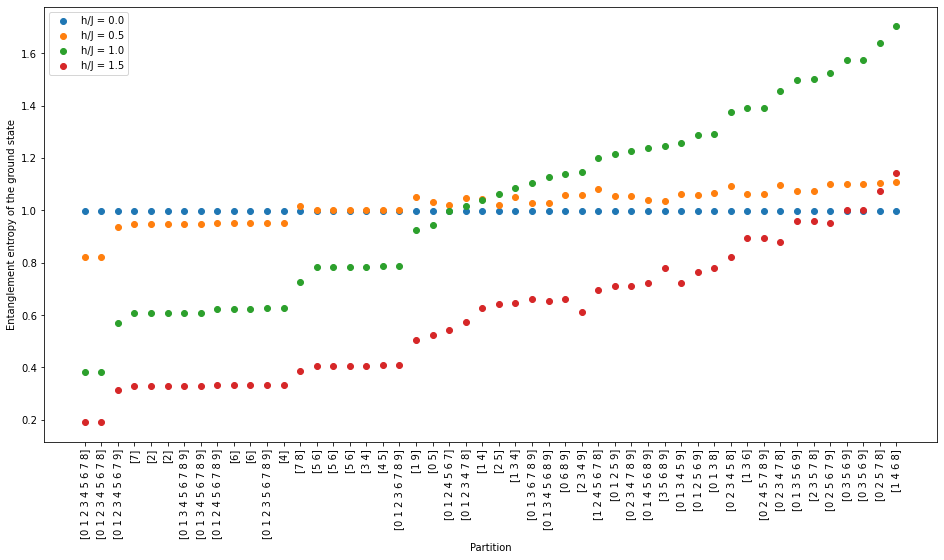

In [59]:
plt.figure(figsize = (16,8))
for i in range(0,len(h)):
    plt.scatter(range(n_partitions), all_entanglement[i], label = 'h/J = %.1f'%h[i])
partition_labels = []
for i in sorted_partitions:
    partition_labels.append(str(i))
plt.ylabel('Entanglement entropy of the ground state')
plt.xlabel('Partition')
plt.legend()
plt.xticks(range(n_partitions), partition_labels, rotation=90)  # Set text labels and properties.
plt.show()

# Energy and entanglement of the three lowest eigenstates

Minimum energy difference ground and excited 2 happens at h/J =  0.8421052631578947


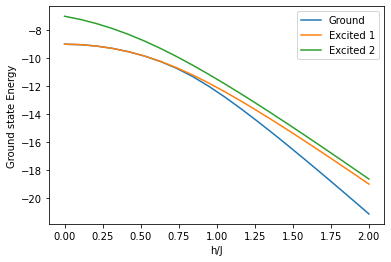

In [25]:
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = np.linspace(0,2,20)
E1 = [] # energy of the ground state
E2 = [] # energy of the first excited state
E3 = [] # energy of the second excited state
entanglement1 = [] # entanglement entropy of the ground state
entanglement2 = []
entanglement3 = []
for i in range(len(h)):
    h_i = h[i]*np.ones(N)

    H = generate_Hamiltonian(N, h_i, Jx, Jy)
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    energies = eigenstates[0]
    states = eigenstates[1]
    E1.append(energies[0])
    E2.append(energies[1])
    E3.append(energies[2])
    entanglement1.append(entanglement_entropy(states[0], [1,4,6,8]))
    entanglement2.append(entanglement_entropy(states[1], [1,4,6,8]))
    entanglement3.append(entanglement_entropy(states[2], [1,4,6,8]))
plt.plot(h, E1, label = 'Ground')
plt.plot(h, E2, label = 'Excited 1')
plt.plot(h, E3, label = 'Excited 2')
plt.xlabel('h/J')
plt.ylabel('Ground state Energy')
plt.legend()
Dif = np.subtract(E3,E1)
print('Minimum energy difference ground and excited 2 happens at h/J = ',h[list(Dif).index(min(Dif))])

Maximum entanglement for 1st excited happens at h/J =  1.1578947368421053
Maximum entanglement for ground happens at h/J =  0.9473684210526315
Maximum entanglement for 2nd excited happens at h/J =  0.10526315789473684


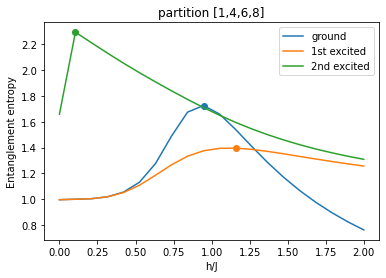

In [26]:
plt.title('partition [1,4,6,8]')
plt.plot(h,entanglement1, label = 'ground')
plt.scatter(h[entanglement1.index(max(entanglement1))],max(entanglement1))
plt.plot(h,entanglement2, label = '1st excited')
plt.scatter(h[entanglement2.index(max(entanglement2))],max(entanglement2))
plt.plot(h,entanglement3, label = '2nd excited')
plt.scatter(h[entanglement3.index(max(entanglement3))],max(entanglement3))
plt.xlabel('h/J')
plt.ylabel('Entanglement entropy')
plt.legend()
print('Maximum entanglement for 1st excited happens at h/J = ',h[entanglement2.index(max(entanglement2))])
print('Maximum entanglement for ground happens at h/J = ',h[entanglement1.index(max(entanglement1))])
print('Maximum entanglement for 2nd excited happens at h/J = ',h[entanglement3.index(max(entanglement3))])

# Correlations
$\displaystyle  \langle\sigma_x(i) \sigma_x(j)\rangle$

In [32]:
# Open boundary conditions
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = [0, 0.5, 1, 1.5]
E = [] # energy of the ground state
corr = []
for i in range(len(h)):
    h_i = h[i]*np.ones(N)
    H = generate_Hamiltonian(N, h_i, Jx, Jy, periodic = False)
    ground = H.groundstate(sparse=False, tol=0, maxiter=100000)
    corr.append(correlation_spins(ground[1], 0, N))

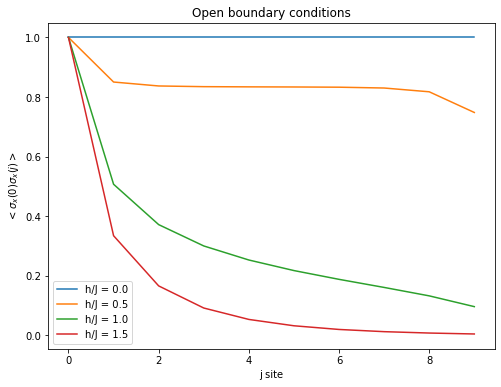

In [36]:
plt.figure(figsize = (8,6))
plt.title('Open boundary conditions')
for i in range(0, len(h)):
    plt.plot(range(N), corr[i], label = 'h/J = %.1f'%h[i])
plt.xlabel('j site')
plt.ylabel('$<\sigma_x(0)\sigma_x(j)>$')
plt.legend()

In [37]:
# Periodic boundary conditions
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = [0, 0.5, 1, 1.5]
E = [] # energy of the ground state
corr = []
for i in range(len(h)):
    h_i = h[i]*np.ones(N)
    H = generate_Hamiltonian(N, h_i, Jx, Jy, periodic = True)
    ground = H.groundstate(sparse=False, tol=0, maxiter=100000)
    corr.append(correlation_spins(ground[1], 0, N))

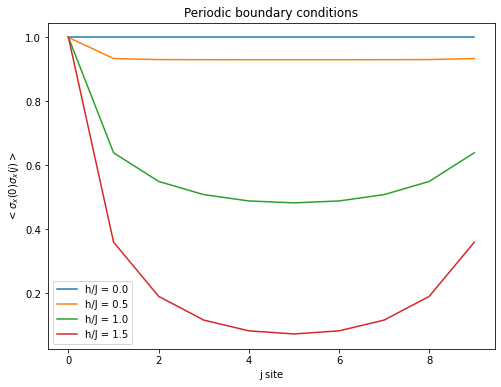

In [38]:
plt.figure(figsize = (8,6))
plt.title('Periodic boundary conditions')
for i in range(0, len(h)):
    plt.plot(range(N), corr[i], label = 'h/J = %.1f'%h[i])
plt.xlabel('j site')
plt.ylabel('$<\sigma_x(0)\sigma_x(j)>$')
plt.legend()

# Entanglement entropy evolution of states in different phases
For h/J=0, 0.5, 1, 2, 10 (corresponding to different phases, phase transition happens approx at h/J = 1), we will take a state consisting of a random superposition of the 50 lowest eigenstates of H in each case and see how the entanglement entropy of this state evolves in time.

Initial state is the superposition of the m=50  lowest eigenstates for H with h/J=0.0
Initial state is the superposition of the m=50  lowest eigenstates for H with h/J=0.5
Initial state is the superposition of the m=50  lowest eigenstates for H with h/J=1.0
Initial state is the superposition of the m=50  lowest eigenstates for H with h/J=2.0
Initial state is the superposition of the m=50  lowest eigenstates for H with h/J=10.0


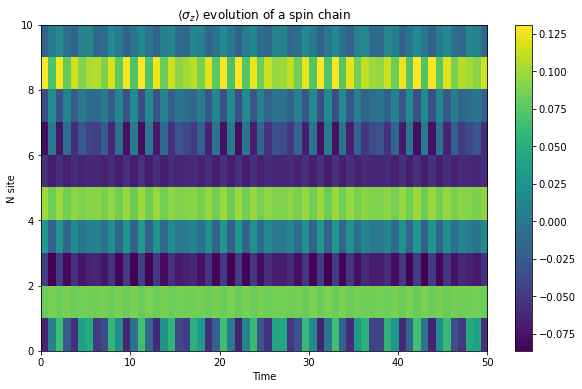

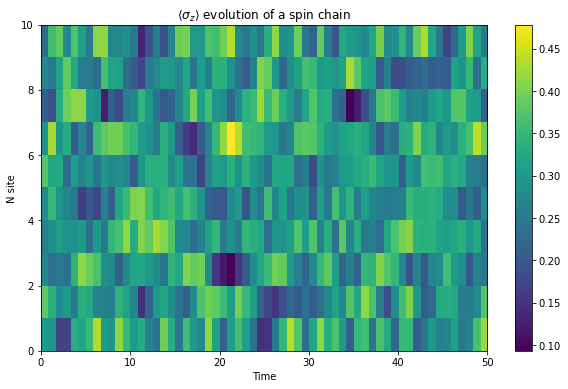

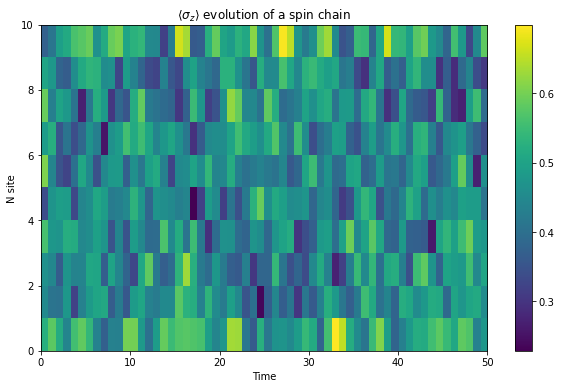

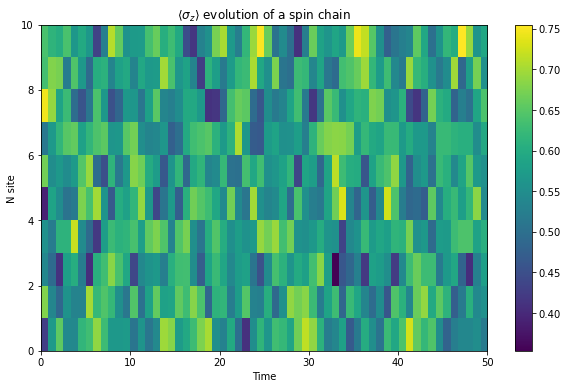

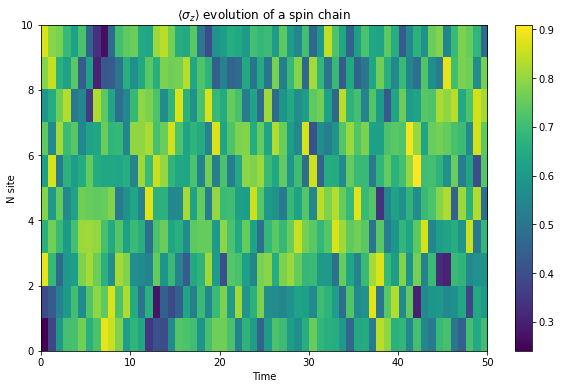

In [40]:
N = 10
m = 50 # number of eigenstates of H to be considered
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = [0, 0.5, 1, 2, 10]
tlist = np.linspace(0, 50, 60)
entanglement = []
random = np.random.rand(m) # array of m numbers from an uniform distribution in [0,1]
partition = [1,4,6,8]

# generate initial states
for i in range(len(h)):
    h_i = h[i]*np.ones(N)
    H = generate_Hamiltonian(N, h_i, Jx, Jy)
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    energies = eigenstates[0]
    states = eigenstates[1]
    psi0 = random[0]*states[0]
    for j in range(1,m):
        psi0 += random[j]*states[j]
    psi0 = psi0.unit()
    print('Initial state is the superposition of the m=%.f'%m,' lowest eigenstates for H with h/J=%.1f'%h[i])
    expectation, evolved_state = evolve_state(H, psi0, tlist, plot = True)
    entanglement_i = []
    for state in evolved_state:
        entanglement_i.append(entanglement_entropy(state,partition))
    entanglement.append(entanglement_i)

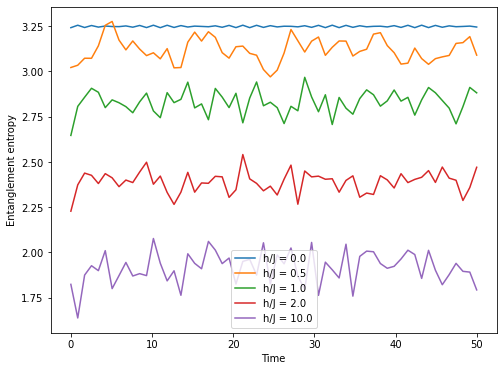

In [43]:
plt.figure(figsize = (8,6))
for i in range(0,len(entanglement)):
    plt.plot(tlist, entanglement[i], label = 'h/J = %.1f'%h[i])
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend()

# Change of phase for each site in the ground state
We calculate the entanglement entropy of each site with respect to the rest of the chain as a function of h/J

In [18]:
N = 10
J = 1
kappa = 1
Jx = (1+kappa)/2*np.ones(N)
Jy = (1-kappa)/2*np.ones(N)
h = np.linspace(0,5,40)
entanglement = np.zeros((N, len(h)))
for i in range(len(h)):
    h_i = h[i]*np.ones(N)
    H = generate_Hamiltonian(N, h_i, Jx, Jy, periodic = False)
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    energies = eigenstates[0]
    states = eigenstates[1]
    for n in range(N):
        partition = [n]
        entanglement[n,i] = entanglement_entropy(states[0], [n])

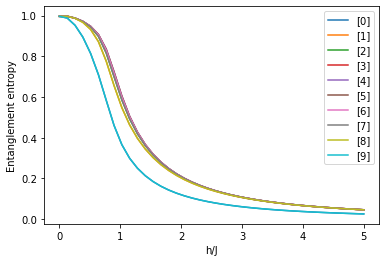

In [19]:
# Entanglement entropy of the ground state
for i in range(N):
    plt.plot(h,entanglement[i], label = '[%.f]'%i)
    #plt.scatter(h[(entanglement[i]).index(max(entanglement[i]))],max(entanglement[i]))
    #print('Maximum entanglement for site %.f'i,' happens at h/J = ',h[entanglement[i].index(max(entanglement[i]))])
plt.xlabel('h/J')
plt.ylabel('Entanglement entropy')
plt.legend()